# 3_A_solve_analogies
- author: Eu-Bin KIM
- 17th of August 2021

## 목표
1. 사전훈련된 Word2Vec 모델을 활용하여 비유문제를 푸는 함수, `solve_analogy()` 함수를 구현하는 것이 이번 숙제의 주된 목표입니다.
2. 재밌는 비유를 찾아보세요! (e.g. `밤:낮::달:X`)
3. 편향(bias) 문제에 대해서도 고민해볼 것입니다. (e.g. 사회에서 남자와 여자의 역할을 모델은 어떻게 판단할까?)


In [1]:
# 이번에는 gensim 라이브러리를 사용해보겠습니다.
# https://radimrehurek.com/gensim/auto_examples/index.html
!pip3 install gensim  
from typing import List, Tuple
from gensim.models import KeyedVectors
import gensim.downloader as api
import numpy as np

# 모델의 다운로드 현황을 확인하기 위해서 로깅 레벨을 수정합니다.
from sys import stdout
import logging
logging.basicConfig(stream=stdout, level=logging.INFO)

In [2]:
# --- 전역 상수 및 변수 설정 --- #
TOP_N = 20
# 차원의 크기 = 200으로 설정하여 학습을 진행한 Word2Vec (정확히는 Glove라는 모델)를 로드해보려고 합니다.
WORD2VEC_MODEL = "glove-wiki-gigaword-200"
# 사전훈련된 모델을 다운로드 (252.MB) 정도되는 모델.
# 모델의 가중치 ("projection weights")를 로드하는데 시간이 좀 걸릴 겁니다.
# 다운로드 가능한 다른 모델 리스트는 https://github.com/RaRe-Technologies/gensim-data#available-data
# 여기에서 확인해볼 수 있습니다.
wv: KeyedVectors = api.load(WORD2VEC_MODEL)

INFO:gensim.api:Creating /root/gensim-data
[==================================================] 100.0% 252.1/252.1MB downloaded
INFO:gensim.api:glove-wiki-gigaword-200 downloaded
INFO:gensim.models.utils_any2vec:loading projection weights from /root/gensim-data/glove-wiki-gigaword-200/glove-wiki-gigaword-200.gz
INFO:gensim.models.utils_any2vec:loaded (400000, 200) matrix from /root/gensim-data/glove-wiki-gigaword-200/glove-wiki-gigaword-200.gz


**Q: `KeyedVectors` 로는 무엇을 할 수 있나요?**
> A: 어휘에 존재하는 단어의 임베딩 벡터를 불러올 수 있고 [(`wv.get_vector()`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.get_vector), 주어진 단어 혹은 단어 벡터와 유사한 단어를 확인할 수 있는 [(`wv.similar_by_word()`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.similar_by_word) , [`wv.similar_by_vector()`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.similar_by_vector) 멤버 함수를 지원하는 객체입니다.
  


In [3]:
# --- wv 사용예시 --- # 
# wv.get_vector(단어)를 사용하여, 어휘에 존재하는 특정 단어의 임베딩 벡터를 넘파이 배열로 불러올 수 있습니다.
car_vec: np.ndarray = wv.get_vector("car")

# Word2Vec 모델은 예측 기반 모델이므로, 벡터가 희소하지 않으며 밀도가 높습니다. 
print(car_vec)

# 벡터의 크기를 200으로 설정한 후 학습한 모델이니, 당연히 벡터의 차원은 200일 것입니다.
print(car_vec.shape)

# similar_by_word로 어휘에 존재하는 단어로 유사어를 구해볼 수 있습니다.
for word, score in wv.similar_by_word("car", topn=TOP_N):
  print(word, score)
print("-----")

# similar_by_vector로는 임베딩 벡터로 유사어를 구해볼 수 있습니다.
for word, score in wv.similar_by_vector(car_vec, topn=TOP_N):
  print(word, score)

# ----------------- #

[ 1.5682e-02  1.9355e-01 -5.5093e-01 -7.0453e-02 -6.5923e-01  2.5597e-01
 -3.4435e-01 -1.7964e-01  6.3907e-01 -4.1880e-01  3.1996e-01  3.3546e-01
  2.1122e-01  4.1592e-01  2.8599e-01 -2.5777e-01 -1.3341e-01 -2.5731e-01
  2.7712e-01 -3.2695e-01  1.1008e-01  2.7322e+00  4.6684e-01 -7.3542e-01
  1.1934e-01 -6.0756e-01  1.8882e-01  1.6739e-01  7.1712e-02 -6.5601e-01
 -5.1485e-01  7.6970e-01 -1.6761e-02 -1.9893e-01  2.7478e-01  1.5767e-01
  3.0154e-03 -3.5170e-01  1.3830e-01  6.0107e-01  1.9442e-01 -1.1802e-01
 -7.5983e-01  6.8567e-01  3.1139e-01  2.6280e-01  3.9558e-01 -6.9782e-01
 -2.1649e-01 -2.9196e-01  2.5405e-02  2.3887e-01  7.7817e-01 -4.7592e-02
 -2.3215e-01  6.1213e-02 -4.8265e-02 -2.0152e-01  3.2679e-01 -3.4759e-01
  9.9897e-02 -5.1759e-01 -5.9987e-01  1.3594e-01  9.4825e-03 -9.0824e-01
 -1.3166e-01 -3.7136e-01 -9.6381e-02 -4.3759e-01 -1.5774e-01  3.3517e-01
  1.3741e-01  8.2091e-02 -3.2295e-01  2.4789e-01 -7.3261e-03  2.5045e-03
 -1.0734e-01  3.8338e-01 -4.6347e-01 -1.7817e-01  2

**Q: 벡터의 연산으로 `A:B::C:X`를 만족하는 가장 적절한 X를 어떻게 구할 수 있을까요?**

`A:B::C:X` 를 풀어서 생각을 해보면,

`관계(A,B)` ~= `관계(C, X)`를 만족하는 가장 적절한 `X`를 찾는 과정이라고 생각해볼 수 있습니다.

그럼 두 `관계`가 동일하다는 것은 어떻게 수학적으로 정의할 수 있을까요? 

만약 두 벡터 사이의 차(Difference)가 유사하다면, 같은 `관계`에 있다고 볼 수 있을 것입니다, 즉 위 식을 `A - B = C - X`로 나타낼 수 있습니다.

예를 들어,
- `king:man::queen:x`
-  = `관계(king,man) ~= 관계(queen,X)`
-  = `king - man ~= queen - x`
-  =  `x ~= queen - king + man`
-  =  `x` ~= woman, girl, etc





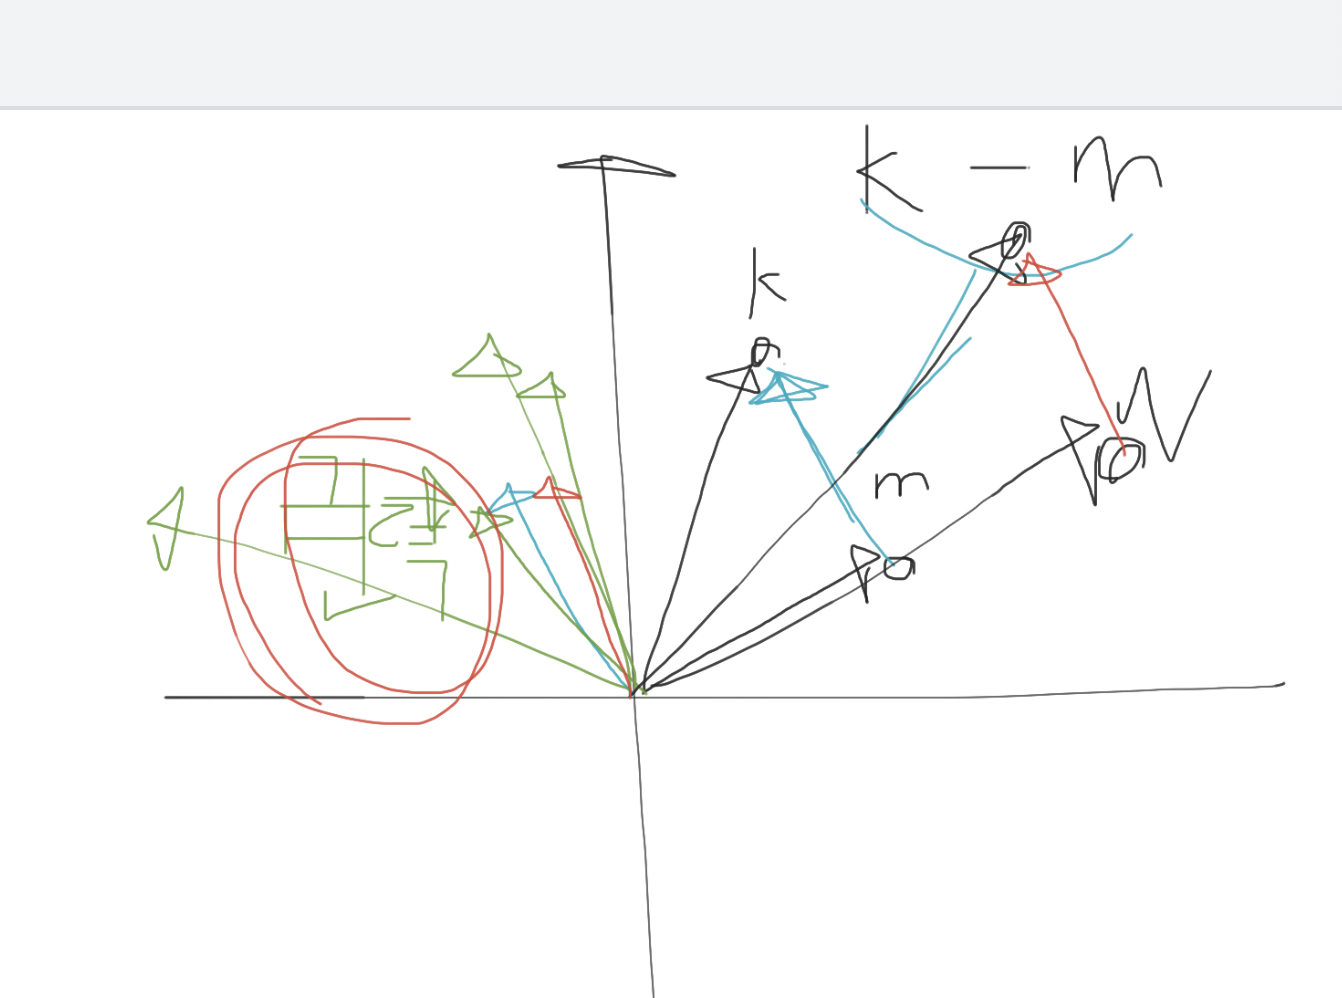

In [4]:
# king - man = 권력 = queen - woman
king_vec = wv.get_vector("king")
man_vec = wv.get_vector("man")
km_vec = king_vec - man_vec  # 관계(king, man)

queen_vec = wv.get_vector("queen")
woman_vec = wv.get_vector("woman")
qw_vec = queen_vec - woman_vec


for word, score in wv.similar_by_vector(km_vec):  # k - m과 유사한 단어들
  print(word, score)

print("--")
for word, score in wv.similar_by_vector(qw_vec):  # q - X과 유사한 단어들
  print(word, score)

king 0.6220163106918335
jeongjo 0.5617712736129761
seongjong 0.5423533916473389
vajiravudh 0.5373874306678772
seonjo 0.5194161534309387
taejong 0.5177606344223022
injo 0.514464259147644
bagyidaw 0.5124008655548096
kalākaua 0.5123972296714783
alveda 0.5079326033592224
--
queen 0.5596188306808472
seondeok 0.4919939339160919
ranavalona 0.4457913637161255
monineath 0.4434443712234497
aiswarya 0.44089972972869873
liliuokalani 0.4362812638282776
ethelburga 0.4357687532901764
trux 0.4262790381908417
gorgo 0.4210543632507324
coronation 0.41778361797332764


In [9]:
def solve_analogy(a: str, b: str, c: str):
    """
    :param wv: a pre-trained word2vec model
    :param a: word a
    :param b: word b
    :param c: word c
    """
    global TOP_N, RESTRICT_VOCAB, wv
    # ---- TODO 1 -------
    # Write your implementation here.
    # get a continuous & distributed vector representation of a, b and c, using wv.
    # use vector arithmetics to get a vector representation of x, such that a is to b as in c is to x.
    # a:b = c:x
    a_vec = wv.get_vector(a)
    b_vec = wv.get_vector(b)
    c_vec = wv.get_vector(c)  
    x = c_vec - a_vec + b_vec
    sims: List[Tuple[str, float]] = [
                                     (word, score)
                                     for word, score in wv.similar_by_vector(x, topn=TOP_N)
    ]  
    # ------------------
    print("=== {} : {} = {} : X ===".format(a, b, c))
    for word, score in sims:
        print(word, score)

In [10]:
# 한번 비유문제를 풀어봅시다!
solve_analogy("king", "man", "queen")  # 왕:남자::여왕:X
solve_analogy("have", "had", "get")  # have:had::get:X
solve_analogy("korea", "seoul", "england")  # 한국:서울::영국:X
solve_analogy("night", "noon", "moon")  # 밤:낮::달:X
solve_analogy("korea", "kimchi", "england")  # 한국:김치::영국:X?
solve_analogy("us", "trump", "korea")  # 미국:트럼프::한국:X?

=== king : man = queen : X ===
woman 0.7018729448318481
man 0.6981476545333862
girl 0.5718171000480652
she 0.5551059246063232
her 0.546249508857727
mother 0.5334489345550537
queen 0.5116901397705078
beautiful 0.509249210357666
teenager 0.5078386664390564
person 0.5015807151794434
boy 0.49607059359550476
herself 0.4940054416656494
wife 0.4905710220336914
men 0.49014854431152344
blonde 0.48988908529281616
young 0.48825371265411377
lady 0.4844915270805359
one 0.4833947420120239
blond 0.4832534193992615
life 0.48230481147766113
=== have : had = get : X ===
got 0.8583781123161316
get 0.8212234973907471
getting 0.7435371279716492
had 0.7194944024085999
him 0.713526725769043
'd 0.7016146183013916
when 0.7001579999923706
just 0.6940717101097107
out 0.6917241811752319
then 0.6907411813735962
me 0.6866481304168701
put 0.6853894591331482
up 0.682799220085144
wanted 0.6817044019699097
did 0.6783760786056519
never 0.6740534901618958
gets 0.6721766591072083
knew 0.6705450415611267
i 0.66871750354766

다음과 같은 결과가 나와야 합니다:
```
### king : man = queen : X ###
woman 0.7018729448318481
man 0.6981476545333862
girl 0.5718171000480652
she 0.5551059246063232
her 0.546249508857727
mother 0.5334489345550537
queen 0.5116901397705078
beautiful 0.509249210357666
teenager 0.5078386664390564
person 0.5015807151794434
### have : had = get : X ###
got 0.8583781123161316
get 0.8212234973907471
getting 0.7435371279716492
had 0.7194944024085999
him 0.713526725769043
'd 0.7016146183013916
when 0.7001579999923706
just 0.6940717101097107
out 0.6917241811752319
then 0.6907411813735962
### korea : seoul = england : X ###
england 0.7255815267562866
london 0.6356680989265442
birmingham 0.589836835861206
surrey 0.5772858262062073
manchester 0.5481588840484619
oxford 0.529553234577179
melbourne 0.5265653133392334
liverpool 0.5259275436401367
nottingham 0.5229343175888062
perth 0.5212391018867493
### night : noon = moon : X ###
moon 0.7155050039291382
noon 0.539372444152832
lunar 0.4896060824394226
enceladus 0.46816378831863403
ki 0.45321711897850037
mullican 0.4399142861366272
gibbous 0.4230325222015381
mid-autumn 0.4199249744415283
earth 0.41744324564933777
sun 0.41505134105682373
### korea : kimchi = england : X ###
surrey 0.4262450635433197
warwickshire 0.42526546120643616
sussex 0.4186975955963135
england 0.41754770278930664
lancashire 0.4137398898601532
alastair 0.41208115220069885
atherton 0.4097963273525238
worcestershire 0.4054810702800751
chowder 0.3995121419429779
botham 0.3986336588859558
### us : trump = korea : X ###
trump 0.5992231369018555
korea 0.5070021152496338
pyongyang 0.41019734740257263
incheon 0.3933596611022949
kathie 0.3807404041290283
knauss 0.3795280456542969
kang 0.36351221799850464
ivanka 0.361664354801178
koreas 0.36132609844207764
dprk 0.3603391647338867
```

In [11]:
# --- TODO 2 --- # 
# 더 재밌는 비유의 예시를 찾아보세요!
solve_analogy("dolphin", "mammal", "alligator")
solve_analogy("dolphin", "mammal", "human")
solve_analogy("dolphin", "mammal", "frog")
solve_analogy("ironman", "hero", "joker")
solve_analogy("space", "blackhole", "human")
# -------------- #

=== dolphin : mammal = alligator : X ===
mammal 0.7057822942733765
alligator 0.596634566783905
reptile 0.5738593935966492
reptiles 0.5121619701385498
ungulate 0.4853922724723816
mammals 0.47988221049308777
fossils 0.4798140823841095
lizard 0.47201842069625854
rodent 0.4641300439834595
crocodile 0.4561908543109894
extinct 0.44991007447242737
fossilized 0.43965768814086914
vertebrates 0.43871909379959106
lizards 0.4329559803009033
amphibians 0.42951029539108276
dinosaur 0.42940300703048706
rodents 0.4245346486568451
amphibian 0.41898074746131897
prehistoric 0.41696256399154663
insect 0.41501903533935547
=== dolphin : mammal = human : X ===
human 0.7432583570480347
mammal 0.6222789883613586
beings 0.543315052986145
animal 0.5300144553184509
humans 0.5153862833976746
animals 0.5045786499977112
mammals 0.46299099922180176
humankind 0.46165919303894043
humanity 0.46155643463134766
fossils 0.45773014426231384
rights 0.4541734755039215
organisms 0.4541313350200653
organism 0.4509585499763489
b

앞선 수업에서, Distributional Semantics 가정을 기반으로 데이터로부터 임베딩 벡터를 얻는 방법은, 편향(bias)을 고려하지 않는 실수를 범하기 쉽다고 했었습니다. 편향관리를 실패한 대표적인 예시로 [이루다 서비스](https://media.scatterlab.co.kr/1-11-media)를 예시로 들기도 했었구요. 

비단 우리가 지금 사용하고 있는 Word2Vec 모델도 편향된 부분이 있을 것입니다. 우리가 구현한 `solve_analogy()` 함수를 활용해 학습한 편향을 찾아보도록 하겠습니다. 

## TODO 3
> 밑의 코드를 실행하고, 결과를 비교해보세요. 어떤 문제를 발견할 수 있나요?

편향이 존재하긴 하는데,  이게 과연 모델의 잘못인가? 과연 잘못된 데이터를 학습했기 때문에
나온 결과라고 볼 수 있는가?

이정무14:59
아뇨
사회통념을 그대로 학습한 거기떄문에 모델의 잘못은 없다고 봅니다. 


그런데 왜 그런 모델을 만들면, 질타를 받는가?

우리 인간은 도의적인 책임을 느낀다. 윤리적인 책임감을 느껴야.
인간이 그렇다면, 인간 수준의 지능을 만들고 싶다라는 것은, 그 인공지능 또한 도의적인 책임을 느껴야하지 않을까? -> AI Fairness.

In [12]:
# 남자의 역할이 노동자라면, 여자의 역할은 무엇인가?
solve_analogy("man", "worker", "woman")  
# 여자의 역할이 노동자라면, 남자의 역할은 무엇인가?
solve_analogy("woman", "worker", "man") 

=== man : worker = woman : X ===
worker 0.8469680547714233
woman 0.6489056348800659
employee 0.6411648988723755
workers 0.6075609922409058
nurse 0.5941476821899414
mother 0.5538603067398071
pregnant 0.5518734455108643
child 0.5260860919952393
teacher 0.5216445922851562
employer 0.5152565240859985
female 0.5103510022163391
homemaker 0.5048410892486572
waitress 0.5033119916915894
nurses 0.49936389923095703
elderly 0.49910637736320496
wife 0.4987758696079254
housewife 0.4957857131958008
maid 0.4885651469230652
employees 0.4863051772117615
schoolteacher 0.4851081371307373
=== woman : worker = man : X ===
worker 0.7736103534698486
workers 0.6012227535247803
employee 0.5834685564041138
man 0.5822302103042603
working 0.5432349443435669
laborer 0.537001371383667
unemployed 0.5245610475540161
job 0.5122866034507751
work 0.5073323249816895
mechanic 0.5002841949462891
worked 0.4903597831726074
factory 0.48811790347099304
wages 0.4727928340435028
labor 0.4683865010738373
laborers 0.467061221599578